In [18]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline


import pyspark
from pyspark import SparkContext
from pyspark.sql.types import *
import pyspark.sql.functions as func
from pyspark.sql import udf
import pyspark.sql.functions as F

sc.stop() # If there is any previous SparkContext already running stop it !

In [19]:
sc = SparkContext("local","prateesh")
 
sqlContext = pyspark.SQLContext(sc)

In [20]:
data_schema = [StructField('id', IntegerType(), True), 
               StructField('name', StringType(), True),
               StructField('host_id', IntegerType(), True),
               StructField('host_name', StringType(), True),
               StructField('neighbourhood_group', StringType(), True),
               StructField('neighbourhood', StringType(), True),
               StructField('latitude', FloatType(), True),
               StructField('longitude', FloatType(), True),
               StructField('room_type', StringType(), True),
               StructField('price', IntegerType(), True),
               StructField('minimum_nights', IntegerType(), True),
               StructField('number_of_reviews', IntegerType(), True),
               StructField('last_review', DateType(), True),
               StructField('reviews_per_month', FloatType(), True),
               StructField('calculated_host_listings_count', IntegerType(), True),
               StructField('availability_365', IntegerType(), True),
              ]

In [21]:
final_struc = StructType(data_schema)

In [22]:
df = sqlContext.read.csv('gs://ethereum-bucket1/notebooks/jupyter/Airbnb_NY.csv', 
                         header = True,schema = final_struc,mode="DROPMALFORMED")

In [23]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: date (nullable = true)
 |-- reviews_per_month: float (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



In [160]:
def sparkShape(dataFrame):
    return (dataFrame.count(), len(dataFrame.columns))

pyspark.sql.dataframe.DataFrame.shape = sparkShape
print(df.shape())

(47571, 20)


In [24]:
df_neigh_gr_pd = df.groupBy("neighbourhood_group").agg(func.mean("price").alias("mean_price")
                                                      ).orderBy('mean_price', ascending=False).toPandas().head(10)

In [25]:
df_neigh_gr_pd

,neighbourhood_group,mean_price
0,Manhattan,196.743216
1,Brooklyn,124.398404
2,Staten Island,114.994595
3,Queens,99.576909
4,Bronx,87.728704
5,Greenwich Village,55.500000
6,Jackson Heights,16.000000
7,Clinton Hill,14.000000
8,Brooklyn Heights,14.000000
9,Upper West Side,13.000000


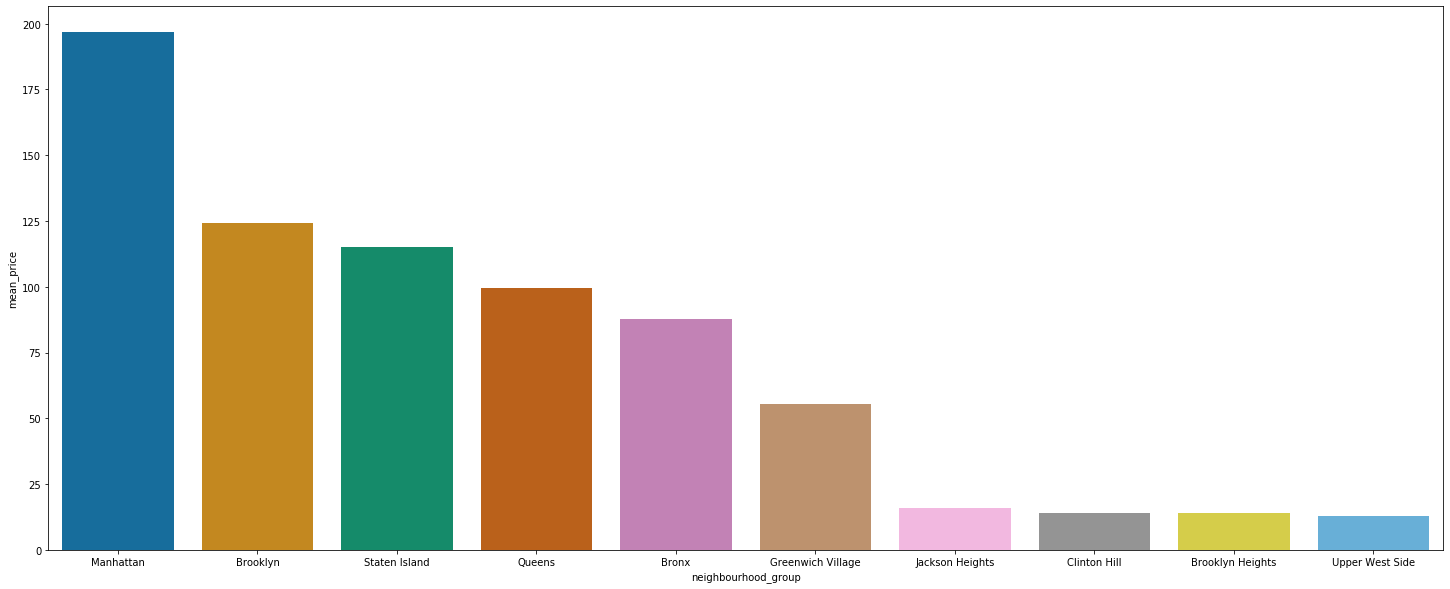

In [98]:
plt.figure(figsize=(25, 10))
sns.barplot(x="neighbourhood_group", y="mean_price", palette = 'colorblind', data=df_neigh_gr_pd)

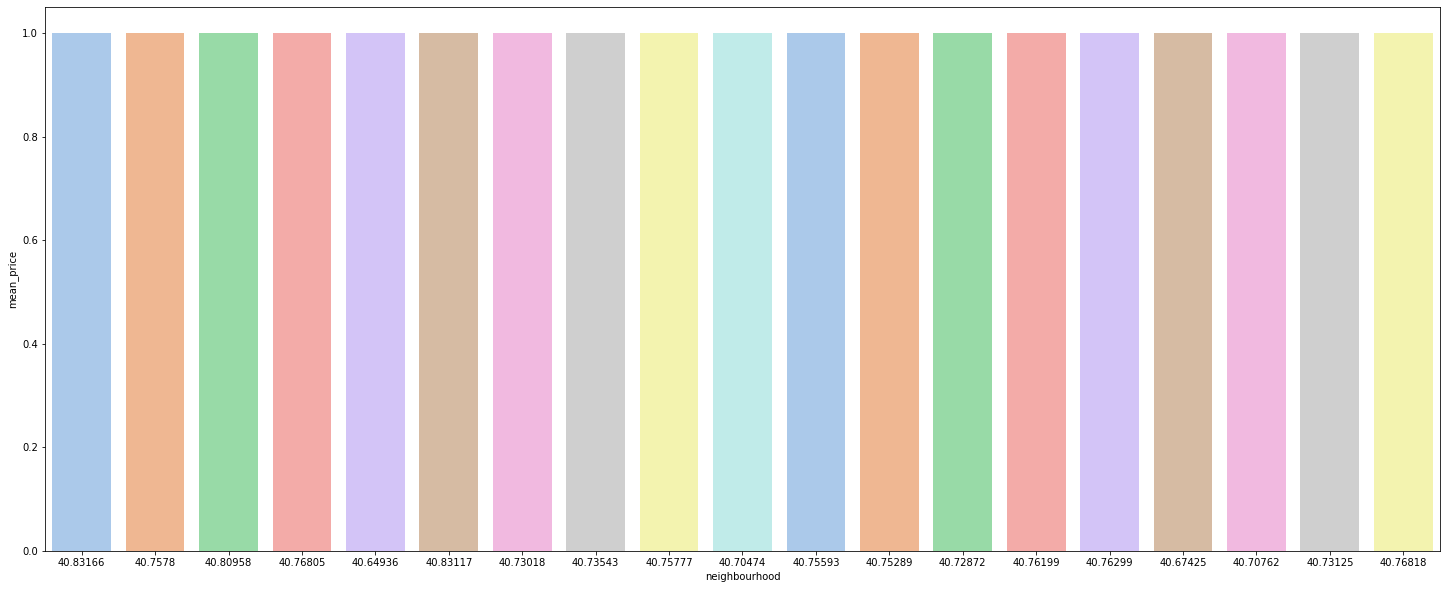

In [97]:
# Mean for each neighbourhood
plt.figure(figsize=(25, 10))
sns.barplot(x="neighbourhood", y="mean_price" , palette = 'pastel',data=df_neigh_pd)

In [30]:
#calculaitng sum of reviews for each host_id
df_host_popularity = df.groupby('host_id').agg(func.sum('number_of_reviews').alias('sum_review'))

In [31]:
#calculating total reviews for complete data
total_reviews = df.select(func.sum('number_of_reviews')).head()[0]

In [32]:
total_reviews

1133522

In [34]:
#Defining function for withcolumn operation and then udf
def func_divide(a1,a2):
      return a1*100.0/float(a2)

In [35]:
divide_func_sp = F.udf(func_divide,FloatType())

In [36]:
#withColumn adds new column and applied the funcition to make new column
df_host_popularity = df_host_popularity.withColumn('total_sum_reviews', F.lit(total_reviews))

In [37]:
df_host_popularity.show()

+--------+----------+-----------------+
| host_id|sum_review|total_sum_reviews|
+--------+----------+-----------------+
|  291112|        35|          1133522|
| 1384111|       103|          1133522|
| 1597481|        13|          1133522|
| 2108853|        18|          1133522|
| 2429432|        27|          1133522|
| 2530670|       134|          1133522|
| 3432742|         2|          1133522|
| 1360296|        13|          1133522|
| 2124690|         1|          1133522|
| 6414252|         1|          1133522|
| 9637768|        47|          1133522|
| 9947836|        87|          1133522|
| 9430366|       159|          1133522|
| 7974574|         5|          1133522|
| 5907325|        32|          1133522|
|13749425|       198|          1133522|
| 5771331|        20|          1133522|
| 9784206|       204|          1133522|
| 4702135|         0|          1133522|
|19239110|        25|          1133522|
+--------+----------+-----------------+
only showing top 20 rows



In [38]:
#creating popularity_index column by diving each host_id reviews by total no. of reviews
df_host_popularity = df_host_popularity.withColumn('popularity_index',
                                                   divide_func_sp('sum_review','total_sum_reviews'))

In [44]:
df_host_popularity.show(10)

+-------+----------+-----------------+----------------+
|host_id|sum_review|total_sum_reviews|popularity_index|
+-------+----------+-----------------+----------------+
| 291112|        35|          1133522|    0.0030877213|
|1384111|       103|          1133522|    0.0090867225|
|1597481|        13|          1133522|    0.0011468679|
|2108853|        18|          1133522|     0.001587971|
|2429432|        27|          1133522|    0.0023819564|
|2530670|       134|          1133522|    0.0118215615|
|3432742|         2|          1133522|    1.7644122E-4|
|1360296|        13|          1133522|    0.0011468679|
|2124690|         1|          1133522|     8.822061E-5|
|6414252|         1|          1133522|     8.822061E-5|
+-------+----------+-----------------+----------------+
only showing top 10 rows



In [45]:
df_host_popularity = df_host_popularity.select('host_id','popularity_index')

In [46]:
df_host_popularity.show()

+--------+----------------+
| host_id|popularity_index|
+--------+----------------+
|  291112|    0.0030877213|
| 1384111|    0.0090867225|
| 1597481|    0.0011468679|
| 2108853|     0.001587971|
| 2429432|    0.0023819564|
| 2530670|    0.0118215615|
| 3432742|    1.7644122E-4|
| 1360296|    0.0011468679|
| 2124690|     8.822061E-5|
| 6414252|     8.822061E-5|
| 9637768|    0.0041463687|
| 9947836|     0.007675193|
| 9430366|     0.014027077|
| 7974574|    4.4110304E-4|
| 5907325|    0.0028230594|
|13749425|      0.01746768|
| 5771331|    0.0017644122|
| 9784206|     0.017997004|
| 4702135|             0.0|
|19239110|    0.0022055153|
+--------+----------------+
only showing top 20 rows



In [49]:
# Merging the popularity_index to the main dataframe
df = df.join(df_host_popularity, "host_id", "left")

In [50]:
df.show(2)

+-------+----+--------------------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+
|host_id|  id|                name|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|
+-------+----+--------------------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+
|   2787|2539|Clean & quiet apt...|     John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|     0.009263163|
|   

In [102]:
# spark filter and sorting 
wc = df.filter(df['minimum_nights'] > 10).orderBy('popularity_index', ascending=False
                                            ).select(df['neighbourhood'])

In [174]:
wc_list = wc.rdd.map(lambda x : x[0]).collect()
wc_py = wc.toPandas()

In [178]:
from collections import Counter
Counter(wc_list)

Counter({'Murray Hill': 213,
         "Hell's Kitchen": 358,
         'Financial District': 222,
         'Upper East Side': 400,
         'Midtown': 406,
         'Theater District': 108,
         'Chelsea': 215,
         'Flushing': 23,
         'Kensington': 20,
         'Windsor Terrace': 19,
         'Bedford-Stuyvesant': 389,
         'Harlem': 293,
         'East New York': 13,
         'South Slope': 26,
         'East Harlem': 104,
         'Williamsburg': 379,
         'Upper West Side': 446,
         'Little Italy': 32,
         'Nolita': 30,
         'Kips Bay': 128,
         'Greenwich Village': 55,
         'Gramercy': 55,
         'East Village': 206,
         'West Village': 113,
         'Flatiron District': 12,
         'Washington Heights': 81,
         'Astoria': 96,
         'Clinton Hill': 66,
         'Bushwick': 254,
         'Sunnyside': 57,
         'Rosedale': 5,
         'Gravesend': 6,
         'Greenpoint': 139,
         'Lower East Side': 90,
         'Ba

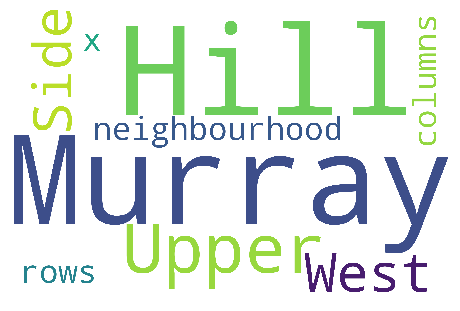

In [159]:
wordcloud = WordCloud(background_color="white", 
                      width=3000, height=2000, max_words=5000).generate(str(wc_py))
plt.figure(figsize=(8,15))
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

In [142]:
#!pip install wordcloud

In [52]:
df_popular_regions = df.groupby('neighbourhood').agg(func.sum('popularity_index').alias('pop_reg'))

In [53]:
df_popular_regions.show()

+------------------+--------------------+
|     neighbourhood|             pop_reg|
+------------------+--------------------+
|            Corona|  0.3798779395292513|
|      Richmondtown|0.006969428155571222|
|      Prince's Bay|0.002029074006713927|
|       Westerleigh|0.001587970909895...|
|        Mill Basin|0.006087222136557102|
|      Civic Center| 0.09210231501492672|
|        Douglaston|0.021966931177303195|
|        Mount Hope| 0.06351883811294101|
|       Marble Hill|  0.0169383569736965|
|         Rego Park|   0.402727072883863|
|     Dyker Heights| 0.07419353185105138|
| Kew Gardens Hills| 0.03793486161157489|
|      Dongan Hills| 0.01817344536539167|
|Financial District|   26.01537540461868|
|       Bay Terrace| 0.02302557899383828|
|           Midtown|   6.244784004520625|
|   Jackson Heights|  1.0536187172110658|
|           Bayside|  0.1852632757218089|
|    Hell's Kitchen|  15.650335770944366|
|        Highbridge|  0.3594107596145477|
+------------------+--------------

In [54]:
df_popular_regions = df_popular_regions.orderBy('pop_reg', ascending=False).toPandas().head(10)

In [55]:
df_popular_regions.head()

,neighbourhood,pop_reg
0,Financial District,26.015375
1,Bedford-Stuyvesant,23.880260
2,Hell's Kitchen,15.650336
3,Harlem,12.463102
4,Williamsburg,12.265223


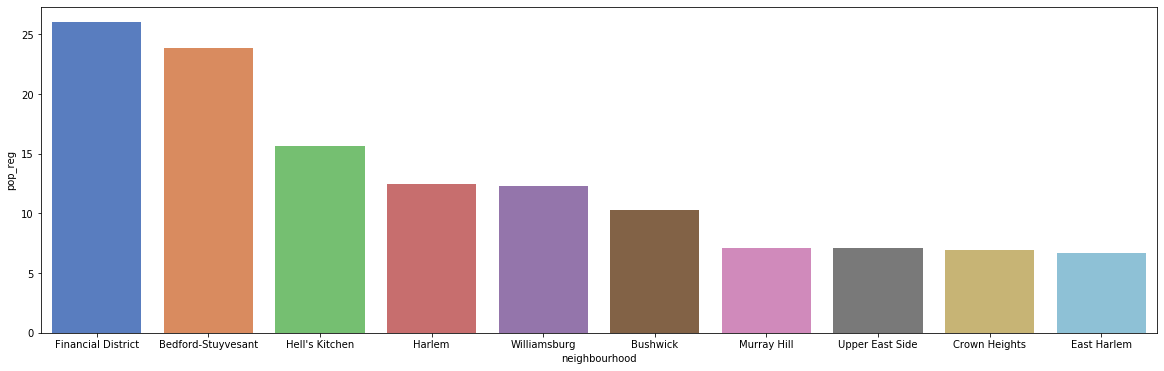

In [166]:
plt.figure(figsize=(20, 6))
sns.barplot(x='neighbourhood', y='pop_reg',palette='muted', data=df_popular_regions)

In [57]:
#Summing no. of reviews for each neighbourhood
df_neighbourhood_sum = df.groupby('neighbourhood').agg(func.sum('number_of_reviews').alias('sum_reviews_ne'))

In [59]:
df_neighbourhood_host_sum = df.groupby('host_id','neighbourhood'
                                      ).agg(func.sum('number_of_reviews').alias('sum_reviews_id_ne'))

In [60]:
df_neighbourhood_host_sum.show()

+--------+--------------------+-----------------+
| host_id|       neighbourhood|sum_reviews_id_ne|
+--------+--------------------+-----------------+
|  829652|            Gramercy|              105|
| 1269455|        West Village|               37|
| 1498424|         Fort Greene|               35|
| 1633100|            Bushwick|               42|
|  160565|  Bedford-Stuyvesant|                3|
| 4241953|            Flushing|               81|
| 3898812|             Astoria|               58|
| 6873370|         Sunset Park|               24|
|  173980|  Bedford-Stuyvesant|              181|
| 1472225|        East Village|               59|
|11192207|     Upper West Side|                2|
|10930874|        Forest Hills|                1|
|16288928|          Park Slope|              136|
| 9604972|     Lower East Side|                1|
|17604079|              Harlem|                1|
|17773625|             Tribeca|               73|
| 2119276|     Upper East Side|               20|


In [61]:
#merging column
df_neighbourhood_host_merged = df_neighbourhood_host_sum.join(df_neighbourhood_sum,'neighbourhood','left')

In [62]:
df_neighbourhood_host_merged.filter(df['neighbourhood'] == 'Williamsburg'
                                   ).orderBy('host_id', ascending=True).show(10)

+-------------+-------+-----------------+--------------+
|neighbourhood|host_id|sum_reviews_id_ne|sum_reviews_ne|
+-------------+-------+-----------------+--------------+
| Williamsburg|   2438|                1|         85368|
| Williamsburg|  10889|              383|         85368|
| Williamsburg|  15991|              148|         85368|
| Williamsburg|  19402|               37|         85368|
| Williamsburg|  21207|                9|         85368|
| Williamsburg|  21306|                2|         85368|
| Williamsburg|  39304|                0|         85368|
| Williamsburg|  45384|               20|         85368|
| Williamsburg|  51414|                9|         85368|
| Williamsburg|  52043|               53|         85368|
+-------------+-------+-----------------+--------------+
only showing top 10 rows



In [63]:
def func_divide(a1,a2):
    if(a2!=0):
        ans = a1*100.0/float(a2)
    else:
        ans = 0
    return ans

In [64]:
divide_func_sp = F.udf(func_divide,FloatType())
df_neighbourhood_host_merged = df_neighbourhood_host_merged.withColumn(
    'host_neighbourhood_popularity',divide_func_sp('sum_reviews_id_ne','sum_reviews_ne'))

In [65]:
df_neighbourhood_host_merged.show()

+-------------+---------+-----------------+--------------+-----------------------------+
|neighbourhood|  host_id|sum_reviews_id_ne|sum_reviews_ne|host_neighbourhood_popularity|
+-------------+---------+-----------------+--------------+-----------------------------+
|       Corona|265288059|                7|          1806|                    0.3875969|
|       Corona|176679165|              156|          1806|                     8.637874|
|       Corona| 32446721|              100|          1806|                    5.5370984|
|       Corona|124042625|                4|          1806|                   0.22148395|
|       Corona| 44620317|              114|          1806|                    6.3122926|
|       Corona| 34129674|                0|          1806|                          0.0|
|       Corona|  5261297|               45|          1806|                    2.4916945|
|       Corona| 98697139|               43|          1806|                    2.3809524|
|       Corona| 31307

In [67]:
df_neighbourhood_host_merged = df_neighbourhood_host_merged.select(
    'host_id','neighbourhood','host_neighbourhood_popularity')

In [68]:
df_neighbourhood_host_merged.show(5)

+---------+-------------+-----------------------------+
|  host_id|neighbourhood|host_neighbourhood_popularity|
+---------+-------------+-----------------------------+
|265288059|       Corona|                    0.3875969|
|176679165|       Corona|                     8.637874|
| 32446721|       Corona|                    5.5370984|
|124042625|       Corona|                   0.22148395|
| 44620317|       Corona|                    6.3122926|
+---------+-------------+-----------------------------+
only showing top 5 rows



In [69]:
#To validate results, for baychester the sum of all the host_neighbourhood_popularity = 100.0
df_neighbourhood_host_merged.filter(df_neighbourhood_host_merged['neighbourhood']=='Baychester').show()

+---------+-------------+-----------------------------+
|  host_id|neighbourhood|host_neighbourhood_popularity|
+---------+-------------+-----------------------------+
|209306758|   Baychester|                     6.774194|
| 64425305|   Baychester|                    0.9677419|
|246653349|   Baychester|                     3.548387|
|129890157|   Baychester|                          0.0|
| 57165692|   Baychester|                     88.70968|
+---------+-------------+-----------------------------+



In [70]:
df = df.join(df_neighbourhood_host_merged,['host_id','neighbourhood'],'left')

In [71]:
df.filter(df['host_neighbourhood_popularity']>90).show(2)

+--------+-------------+--------+--------------------+---------+-------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+
| host_id|neighbourhood|      id|                name|host_name|neighbourhood_group|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|host_neighbourhood_popularity|
+--------+-------------+--------+--------------------+---------+-------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+
| 6402171|    Rossville|26258351|Escape NYC in the...|    Taryn|      Staten Island| 40.5479|-74.21017|Entire home/apt|   75|             3|        

In [72]:
#Filtering only private room and entire room
df_neighbourhood_room_type = df.filter(df['room_type'] != 'Shared room')

In [73]:
df_neighbourhood_room_type = df_neighbourhood_room_type.groupby('neighbourhood','room_type'
                                                               ).agg(func.sum('price').alias('price_sum'))

In [74]:
#pivot operation 
df_neighbourhood_room_type = df_neighbourhood_room_type.groupby('neighbourhood').pivot('room_type').sum('price_sum')

In [75]:
#Maximum revenue in Private Rooms
df_neighbourhood_room_type.orderBy('Private room', ascending=False).show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Williamsburg|         389426|      170841|
+-------------+---------------+------------+
only showing top 1 row



In [76]:
df_min = df_neighbourhood_room_type.orderBy('Private room', ascending=True)

In [77]:
#Minimum revenue in Private Rooms after filetering out null values
df_min[df_min['Private room'].isNotNull()].show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Graniteville|            186|          20|
+-------------+---------------+------------+
only showing top 1 row



In [78]:
#minimum revenue in Entire home/apt Rooms
df_neighbourhood_room_type.orderBy('Entire home/apt', ascending=True
                                  ).filter(df_neighbourhood_room_type['Entire home/apt'].isNotNull()).show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
|     New Dorp|             57|        null|
+-------------+---------------+------------+
only showing top 1 row



In [79]:
#maximum revenue in Entire home/apt Rooms

df_neighbourhood_room_type.orderBy('Entire home/apt', ascending=False).show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Williamsburg|         389426|      170841|
+-------------+---------------+------------+
only showing top 1 row



In [80]:
#Calculating the average price income for private rooms and entire homes for each of the neighbourhoods
df_neighbourhood_room_type_mean = df.filter(df['room_type'] != 'Shared room')

In [81]:
df_neighbourhood_room_type_mean = df_neighbourhood_room_type_mean.groupby('neighbourhood','room_type'
                                                            ).agg(func.mean('price').alias('average_region_price'))

In [82]:
df_neighbourhood_room_type_mean_pivot = df_neighbourhood_room_type_mean.groupby('neighbourhood'
                                                                               ).pivot('room_type').sum('average_region_price')

In [83]:
df_neighbourhood_room_type_mean_pivot.show()

+------------------+------------------+------------------+
|     neighbourhood|   Entire home/apt|      Private room|
+------------------+------------------+------------------+
|            Corona|119.15384615384616|              55.0|
|      Prince's Bay| 506.6666666666667|             118.0|
|      Richmondtown|              78.0|              null|
|        Mill Basin|            179.75|              null|
|       Westerleigh|             103.0|              40.0|
|      Civic Center|226.42857142857142|120.94117647058823|
|        Douglaston|             134.0|             53.75|
|        Mount Hope|             107.9|              47.1|
|       Marble Hill|              91.8| 87.28571428571429|
|         Rego Park|           127.125| 59.08474576271186|
|     Dyker Heights|114.85714285714286|              69.5|
| Kew Gardens Hills|120.70588235294117| 96.44444444444444|
|      Dongan Hills|            101.25|50.333333333333336|
|       Bay Terrace|210.33333333333334|              94.

In [88]:
#Filtering out null values for price
temp1 = df.filter(df['price'].isNotNull())

In [89]:
#Filtering out null values for average_region_price
temp1 = temp1.filter(temp1['average_region_price'].isNotNull())

In [84]:
df_neighbourhood_room_type_mean_pivot = df_neighbourhood_room_type_mean_pivot.toPandas()

<Figure size 576x576 with 0 Axes>

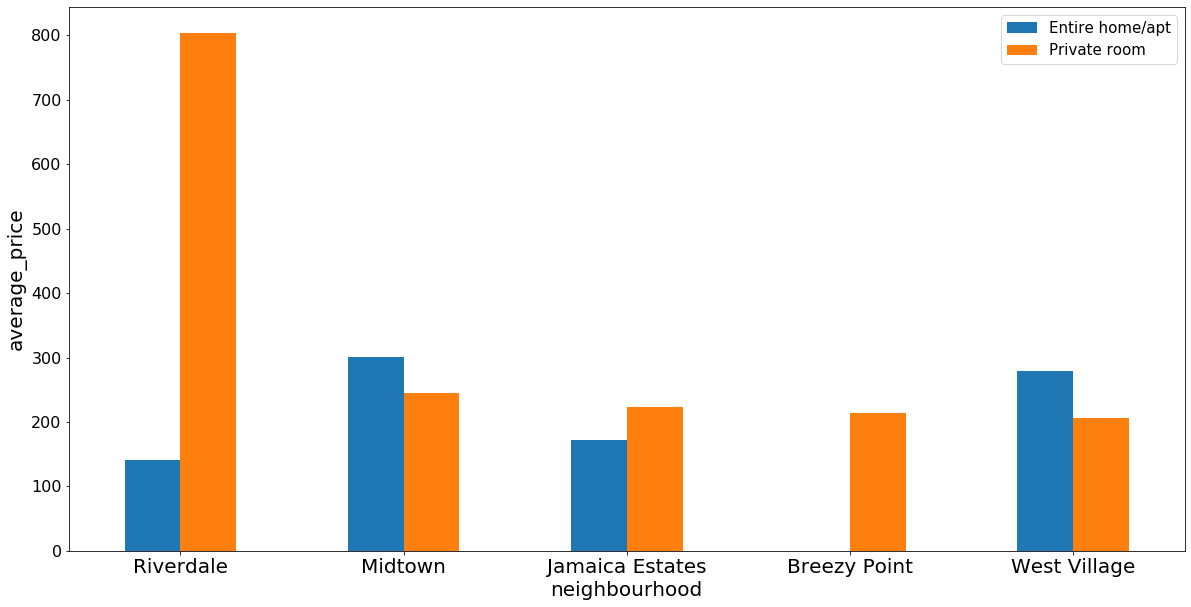

In [171]:
#Plotting 
plt.figure(figsize=(8, 8))
labels = []
ax=df_neighbourhood_room_type_mean_pivot.sort_values('Private room', ascending=False).head().plot(kind='bar', width = 0.5)
ax.set_xlabel('neighbourhood', fontsize = 20)
ax.set_ylabel('average_price', fontsize = 20)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
a = [item.get_text() for item in ax.get_xticklabels()]  #to get labels as they are coming as index
for i in a:
    labels.append(df_neighbourhood_room_type_mean_pivot['neighbourhood'][int(i)])
ax.set_xticklabels(labels)  #setting xticks as neighbourhood name
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation('horizontal')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)     
plt.rcParams["figure.figsize"] = fig_size
plt.legend(prop={'size':'15'})
plt.show(ax)


In [86]:
df = df.join(df_neighbourhood_room_type_mean,['neighbourhood','room_type'],'left')

In [87]:
df.filter(df['neighbourhood'] == 'Kensington').show()

+-------------+------------+---------+--------+--------------------+---------+-------------------+--------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+--------------------+
|neighbourhood|   room_type|  host_id|      id|                name|host_name|neighbourhood_group|latitude|longitude|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|host_neighbourhood_popularity|average_region_price|
+-------------+------------+---------+--------+--------------------+---------+-------------------+--------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+--------------------+
|   Kensington|Private room|  6755111| 1239293|Cozy Retreat in B...|  Jessica|           Br